In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib

sns.set_theme()

In [66]:
result_dir = r"results/2023-02-14-14-47-36-Intel_i7_4770/"
result_dir = pathlib.Path(result_dir)

delimiter = "#"
rows = []

for file in result_dir.iterdir():
    if file.suffix == ".log":
        continue
    name = file.stem
    if "_half" in name:
        is_half = True
        key, start, target = name.split(sep=delimiter)
        key = key.replace("_half", "")
        core_start, thread_start = start.split(",")
        core_target, thread_target = target.split(",")
    else:
        is_half = False
        key, start = name.split(delimiter)
        core_start, thread_start = start.split(",")
        core_target, thread_target = None, None
    run_params = [key, is_half, core_start, thread_start, core_target, thread_target]

    times = []
    energy_pkg = []
    energy_cores = []
    with open(file, "r") as result:
        for line in result:
            line = line.rstrip()
            if line.startswith('#'):
                continue
            val = float(line.split(",")[0])
            if 'duration_time' in line:
                time_s = val * (10**-9)
                times.append(time_s)
            elif 'energy-pkg' in line:
                energy_pkg.append(val)
            elif 'energy-cores' in line:
                energy_cores.append(val)
            else:
                print(f"Found unknown line: {line}")

        rows.append([*run_params, "duration_time", sum(times) / len(times)])
        rows.append([*run_params, "energy-pkg", sum(energy_pkg) / len(energy_pkg) ])
        rows.append([*run_params, "energy-cores", sum(energy_cores) / len(energy_cores)])
df = pd.DataFrame(rows, columns=["name", "half", "core_start", "thread_start", "core_target", "thread_target", "measurement", "value"])
df

,name,half,core_start,thread_start,core_target,thread_target,measurement,value
0,cg.B.x,False,1,1,None,None,duration_time,76.120645
1,cg.B.x,False,1,1,None,None,energy-pkg,2421.800000
2,cg.B.x,False,1,1,None,None,energy-cores,1447.400000
3,cg.B.x,False,1,2,None,None,duration_time,87.114340
4,cg.B.x,False,1,2,None,None,energy-pkg,2700.200000
...,...,...,...,...,...,...,...,...
655,mg.C.x,True,8,8,4,4,energy-pkg,2011.000000
656,mg.C.x,True,8,8,4,4,energy-cores,1666.600000
657,mg.C.x,True,8,8,4,8,duration_time,30.998485
658,mg.C.x,True,8,8,4,8,energy-pkg,2133.400000


## Heatmap (Full, Core, Threads, Energy-PKG)

In [ ]:
only_full = df[df["half"] == False][["name", "core_start", "thread_start", "measurement", "value"]]
only_full = only_full[only_full["measurement"] == "energy-pkg"]

for name, group in only_full.groupby("name"):
    group_heatmap = group.pivot(columns="core_start", index="thread_start", values="value")
    group_heatmap.index.name = "Threads"
    group_heatmap.columns.name = "Cores"
    print(name)
    ax = sns.heatmap(data=group_heatmap, cmap="viridis", annot=True, fmt='.0f', cbar_kws={"label": "Joules"})
    ax.invert_yaxis()
    plt.savefig(f"{name}.png", dpi=300, bbox_inches="tight")
    plt.show()

## Barplot

In [102]:
energy_pkg = df[df["measurement"] == "energy-pkg"]
is_full = energy_pkg["half"] == False

full_runs = energy_pkg[is_full]
merge_columns = [
    "name",
    "core_start", "thread_start",
    "measurement", "value"
]

half_runs = energy_pkg[~is_full]

merged = pd.merge(
    half_runs, full_runs[merge_columns],
    left_on=["name", "core_start", "thread_start"],
    right_on=["name", "core_start", "thread_start"],
    suffixes=("", "_start")
)

merged = pd.merge(
    merged,
    full_runs[merge_columns].rename(columns={"core_start": "core_target", "thread_start": "thread_target"}),
    left_on=["name", "core_target", "thread_target"],
    right_on=["name", "core_target", "thread_target"],
    suffixes=("", "_target")
)

cols = ["name", "core_target", "thread_target",
        "measurement", "value",
        "measurement_start", "value_start",
        "measurement_target", "value_target"]
melted = pd.melt(merged[cols], id_vars=["name", "core_target", "thread_target"], value_vars=["value", "value_start", "value_target"], value_name="val")

melted["key"] = melted["core_target"] + "/" + melted["thread_target"]
melted

,name,core_target,thread_target,variable,val,key
0,cg.B.x,1,1,value,2052.8,1/1
1,cg.B.x,1,8,value,3120.2,1/8
2,cg.B.x,2,2,value,1949.6,2/2
3,cg.B.x,2,8,value,2656.8,2/8
4,cg.B.x,4,4,value,1831.8,4/4
...,...,...,...,...,...,...
175,mg.C.x,1,8,value_target,2023.0,1/8
176,mg.C.x,2,2,value_target,1521.4,2/2
177,mg.C.x,2,8,value_target,1967.0,2/8
178,mg.C.x,4,4,value_target,1905.0,4/4


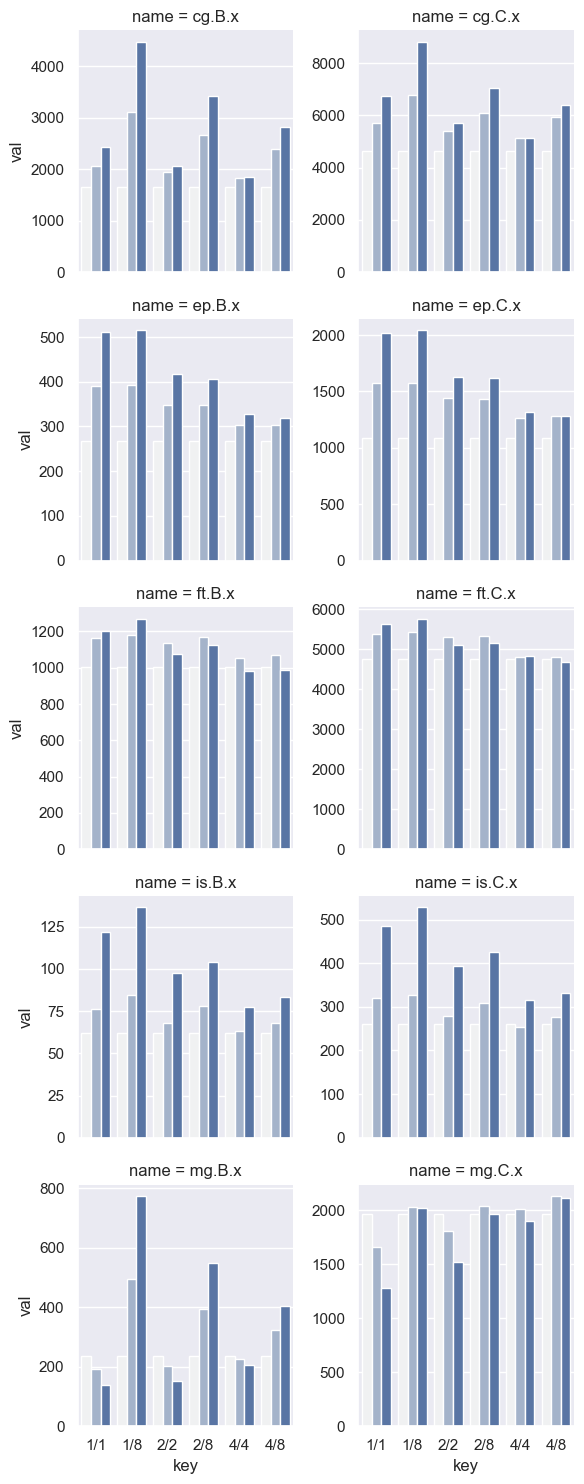

In [106]:
g = sns.FacetGrid(data=melted, col="name", col_wrap=2, sharey=False)
g.map_dataframe(sns.barplot, x="key", y="val", hue="variable",
                hue_order=["value_start", "value", "value_target"])